In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline
plt.style.use('default')

import functools
import warnings

from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter
from scipy.optimize import curve_fit


In [ ]:
def flatten(func):
    ''' Decorator to flatten function parameters '''
    @functools.wraps(func)
    def helper(*args, **kwargs):
        flat_args = [a if a is None else a.flatten() for a in args]
        return func(*flat_args, **kwargs)
    return helper

def validate_shape(func):
	''' Decorator to flatten all function input arrays, and ensure shapes are the same '''
	@functools.wraps(func)
	def helper(*args, **kwargs):
		flat     = [a.flatten() if hasattr(a, 'flatten') else a for a in args]
		flat_shp = [a.shape for a in flat if hasattr(a, 'shape')]
		orig_shp = [a.shape for a in args if hasattr(a, 'shape')]
		assert(all(flat_shp[0] == s for s in flat_shp)), f'Shapes mismatch in {func.__name__}: {orig_shp}'
		return func(*flat, **kwargs)
	return helper

def only_finite(func):
	''' Decorator to remove samples which are nan in any input array '''
	@validate_shape
	@functools.wraps(func)
	def helper(*args, **kwargs):
		stacked = np.vstack(args)
		valid   = np.all(np.isfinite(stacked), 0)
		assert(valid.sum()), f'No valid samples exist for {func.__name__} metric'
		return func(*stacked[:, valid], **kwargs)
	return helper

def only_valid(func):
    ''' Decorator to remove all elements having a nan in any array '''
    @functools.wraps(func)
    def helper(*args, **kwargs):
        assert(all([len(a.shape) == 1 for a in args]))
        stacked = np.vstack(args)
        valid = np.all(np.isfinite(stacked), 0)
        return func(*stacked[:, valid], **kwargs)
    return helper

def only_positive(func):
	''' Decorator to remove samples which are zero/negative in any input array '''
	@validate_shape
	@functools.wraps(func)
	def helper(*args, **kwargs):
		stacked = np.vstack(args)
		valid   = np.all(stacked > 0, 0)
		assert(valid.sum()), f'No valid samples exist for {func.__name__} metric'
		return func(*stacked[:, valid], **kwargs)
	return helper


def label(name):
    ''' Label a function for when it's printed '''
    def helper(f):
        f.__name__ = name
        return f
    return helper

@only_finite
@label('RMSE')
def rmse(y, y_hat):
	''' Root Mean Squared Error '''
	return np.mean((y - y_hat) ** 2) ** .5


@only_finite
@only_positive
@label('RMSLE')
def rmsle(y, y_hat):
	''' Root Mean Squared Logarithmic Error '''
	return np.mean(np.abs(np.log(y) - np.log(y_hat)) ** 2) ** 0.5


@only_finite
@label('NRMSE')
def nrmse(y, y_hat):
	''' Normalized Root Mean Squared Error '''
	return ((y - y_hat) ** 2).mean() ** .5 / y.mean()

@only_finite
@only_positive
@label('R^2')
def r_squared(y, y_hat):
	''' Logarithmic R^2 '''
	slope_, intercept_, r_value, p_value, std_err = stats.linregress(np.log10(y), np.log10(y_hat))
	return r_value**2

@label('<=0')
@flatten
@only_valid
def leqz(y1, y2=None):
    ''' Less than or equal to zero (y2) '''
    if y2 is None: y2 = y1
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        return (y2 <= 0).sum()


@label('<=0|NaN')
@flatten
def leqznan(y1, y2=None):
    ''' Less than or equal to zero (y2) '''
    if y2 is None: y2 = y1
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        return np.logical_or(np.isnan(y2), y2 <= 0).sum()

@label('MAD')
@flatten
@only_valid
def MAD(y1, y2):
    ''' Mean Absolute Error '''
    i  = np.logical_and(y1 > 0, y2 > 0)
    y1 = np.log10(y1[i])
    y2 = np.log10(y2[i])
    i  = np.logical_and(np.isfinite(y1), np.isfinite(y2))
    y1 = y1[i]
    y2 = y2[i]
    return 10**np.mean(np.abs(y1 - y2))-1

@only_finite
@label('MdAPE')
def mape(y, y_hat):
	''' Mean Absolute Percentage Error '''
	return 100 * np.mean(np.abs((y - y_hat) / y))

@only_finite
@only_positive
@label('MSA')
def msa(y, y_hat):
	''' Mean Symmetric Accuracy '''
	# https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017SW001669
	return 100 * (np.exp(np.mean(np.abs(np.log(y_hat / y)))) - 1)


@only_finite
@only_positive
@label('MdSA')
def mdsa(y, y_hat):
	''' Median Symmetric Accuracy '''
	# https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017SW001669
	return 100 * (np.exp(np.median(np.abs(np.log(y_hat / y)))) - 1)

@only_finite
@only_positive
@label('SSPB')
def sspb(y, y_hat):
	''' Symmetric Signed Percentage Bias '''
	# https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017SW001669
	M = np.median( np.log(y_hat / y) )
	return 100 * np.sign(M) * (np.exp(np.abs(M)) - 1)


@only_finite
@label('Bias')
def bias(y, y_hat):
	''' Mean Bias '''
	return np.mean(y_hat - y)

@only_finite
@only_positive
@label('Slope')
def slope(y, y_hat):
	''' Logarithmic slope '''
	slope_, intercept_, r_value, p_value, std_err = stats.linregress(np.log10(y), np.log10(y_hat))
	return slope_


@only_finite
@only_positive
@label('Intercept')
def intercept(y, y_hat):
	''' Locarithmic intercept '''
	slope_, intercept_, r_value, p_value, std_err = stats.linregress(np.log10(y), np.log10(y_hat))
	return intercept_

@validate_shape
@label('MWR')
def mwr(y, y_hat, y_bench):
	'''
	Model Win Rate - Percent of samples in which model has a closer
	estimate than the benchmark.
		y: true, y_hat: model, y_bench: benchmark
	'''
	y_bench[y_bench < 0] = np.nan
	y_hat[y_hat < 0] = np.nan
	y[y < 0] = np.nan
	valid = np.logical_and(np.isfinite(y_hat), np.isfinite(y_bench))
	diff1 = np.abs(y[valid] - y_hat[valid])
	diff2 = np.abs(y[valid] - y_bench[valid])
	stats = np.zeros(len(y))
	stats[valid]  = diff1 < diff2
	stats[~np.isfinite(y_bench)] = 1
	stats[~np.isfinite(y_hat)] = 0
	return stats.sum() / np.isfinite(y).sum()

def performance(key, y1, y2, metrics=[rmse, slope, msa, rmsle, sspb, MAD, leqznan]):#[rmse, rmsle, mape, r_squared, bias, mae, leqznan, slope]):
    ''' Return a string containing performance using various metrics.
        y1 should be the true value, y2 the estimated value. '''
    return '%8s | %s' % (key, '   '.join([
            '%s: %6.3f' % (f.__name__, f(y1,y2)) for f in metrics]))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

# Define the path to the folder
folder_path = '/content/drive/My Drive/iop_ml/datasets_train_test'

# List the contents of the folder
contents = os.listdir(folder_path)
print(contents)


['ood_train_set_2.csv', 'ood_test_set_2.csv', 'filtered_df_2319.csv', 'random_df_train_org.csv', 'random_df_test_org.csv', 'wd_train_set_org.csv', 'wd_test_set_org.csv', 'ood_test_set_org.csv', 'ood_train_set_org.csv']


In [ ]:
import pandas as pd

# Define the base path to the folder
base_path = '/content/drive/My Drive/iop_ml/datasets_train_test'

# Load the three in situ scenarios
random_train_df = pd.read_csv(f'{base_path}/random_df_train_org.csv')
random_test_df = pd.read_csv(f'{base_path}/random_df_test_org.csv')

wd_train_df = pd.read_csv(f'{base_path}/wd_train_set_org.csv')
wd_test_df = pd.read_csv(f'{base_path}/wd_test_set_org.csv')

ood_train_df = pd.read_csv(f'{base_path}/ood_train_set_org.csv')
ood_test_df = pd.read_csv(f'{base_path}/ood_test_set_org.csv')

filtered_df = pd.read_csv(f'{base_path}/filtered_df_2319.csv')

<ipython-input-5-47b43289e051>:8: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  random_test_df = pd.read_csv(f'{base_path}/random_df_test_org.csv')
<ipython-input-5-47b43289e051>:10: DtypeWarning: Columns (3,4,5,6,8,11,27,33,34,37,39,48,50,51,52,54,55,63) have mixed types. Specify dtype option on import or set low_memory=False.
  wd_train_df = pd.read_csv(f'{base_path}/wd_train_set_org.csv')
<ipython-input-5-47b43289e051>:11: DtypeWarning: Columns (4,5,34,37,39,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  wd_test_df = pd.read_csv(f'{base_path}/wd_test_set_org.csv')
<ipython-input-5-47b43289e051>:13: DtypeWarning: Columns (3,6,8,11,27,33,34,52,54,55,63) have mixed types. Specify dtype option on import or set low_memory=False.
  ood_train_df = pd.read_csv(f'{base_path}/ood_train_set_org.csv')
<ipython-input-5-47b43289e051>:14: DtypeWarning: Columns (3,4,5,6,27,33,37,39,48,50,51,52,54,55,63) have

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

# Select Rrs values in 5 nm steps
# data was already scaled
rrs_columns = [f'Rrs_{nm}' for nm in range(400, 701, 5)]
X_train = random_train_df[rrs_columns].values
X_test = random_test_df[rrs_columns].values

# Extracting target variables
y_columns = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']
y_train = random_train_df[y_columns].values
y_test = random_test_df[y_columns].values

# needs scaling
#Apply log transformation to the target variables
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

#Apply Min-Max scaling to log-transformed target variables
scaler_y = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = scaler_y.fit_transform(y_train_log)
y_test_scaled = scaler_y.transform(y_test_log)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from concurrent.futures import ThreadPoolExecutor, as_completed
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

def nll_loss(y_true, y_pred):
    mean = y_pred[:, :6]
    var = tf.nn.softplus(y_pred[:, 6:])
    return tf.reduce_mean(0.5 * (tf.math.log(var) + (tf.square(y_true - mean) / var) + tf.math.log(2 * np.pi)))

def build_deep_regressor_nll(input_shape, output_size=6, depth=5, width=100, l2_reg=1e-3):
    model = Sequential()
    model.add(Dense(width, activation='relu', input_shape=input_shape, kernel_regularizer=l2(l2_reg)))
    for _ in range(depth - 1):
        model.add(Dense(width, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dense(output_size * 2, activation='linear'))
    return model

def train_model(index, X_train, y_train, epochs, batch_size, learning_rate, input_shape, output_size, depth, width, l2_reg):
    # ensure reproducibility with the same dataset
    np.random.seed(index)
    tf.random.set_seed(index)

    model = build_deep_regressor_nll(input_shape=input_shape, output_size=output_size, depth=depth, width=width, l2_reg=l2_reg)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=nll_loss)

    early_stopping = EarlyStopping(monitor='val_loss', patience=80, verbose=1, mode='min', restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping], verbose=2)

    return model, history

# training in parallel via CPUs is faster than GPUs here for an unknown reason
def train_ensemble(X_train, y_train, num_models=10, epochs=1000, batch_size=32, learning_rate=0.001, depth=5, width=100, l2_reg=1e-3):
    models = []
    histories = []
    input_shape = (X_train.shape[1],)
    output_size = 6
    with ThreadPoolExecutor(max_workers=num_models) as executor:
        futures = [
            executor.submit(train_model, i, X_train, y_train, epochs, batch_size, learning_rate, input_shape, output_size, depth, width, l2_reg)
            for i in range(num_models)
        ]
        for future in as_completed(futures):
            model, history = future.result()
            models.append(model)
            histories.append(history)
    return models, histories

# Parameters
num_models = 10
epochs = 1000
batch_size = 32
learning_rate = 0.001
depth = 5
width = 100
l2_reg = 1e-3

# Train the ensemble
models, histories = train_ensemble(
    X_train,
    y_train_scaled,
    num_models=num_models,
    epochs=epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    depth=depth,
    width=width,
    l2_reg=l2_reg
)


Epoch 1/1000
Epoch 1/1000
Epoch 1/1000
Epoch 1/1000
Epoch 1/1000
Epoch 1/1000
Epoch 1/1000
Epoch 1/1000
Epoch 1/1000
Epoch 1/1000
33/33 - 17s - loss: 1.1078 - val_loss: 0.9559 - 17s/epoch - 505ms/step
33/33 - 17s - loss: 1.0847 - val_loss: 0.9086 - 17s/epoch - 505ms/step
Epoch 2/1000
Epoch 2/1000
33/33 - 17s - loss: 1.1444 - val_loss: 0.9330 - 17s/epoch - 518ms/step
Epoch 2/1000
33/33 - 1s - loss: 0.7071 - val_loss: 0.7194 - 859ms/epoch - 26ms/step
Epoch 3/1000
33/33 - 1s - loss: 0.7315 - val_loss: 0.8117 - 1s/epoch - 31ms/step
Epoch 3/1000
33/33 - 18s - loss: 1.0433 - val_loss: 0.9089 - 18s/epoch - 549ms/step
Epoch 2/1000
33/33 - 1s - loss: 0.6985 - val_loss: 0.7632 - 1s/epoch - 40ms/step
Epoch 3/1000
33/33 - 19s - loss: 1.0585 - val_loss: 0.9432 - 19s/epoch - 564ms/step
33/33 - 19s - loss: 1.0502 - val_loss: 0.9336 - 19s/epoch - 567ms/step
Epoch 2/1000
Epoch 2/1000


33/33 - 19s - loss: 1.0560 - val_loss: 0.9937 - 19s/epoch - 575ms/step
Epoch 2/1000
33/33 - 19s - loss: 0.9821 - val_loss: 0.9213 - 19s/epoch - 578ms/step
Epoch 2/1000
33/33 - 19s - loss: 1.0359 - val_loss: 1.0074 - 19s/epoch - 580ms/step
Epoch 2/1000
33/33 - 19s - loss: 1.0987 - val_loss: 0.8832 - 19s/epoch - 582ms/step
Epoch 2/1000
33/33 - 2s - loss: 0.6169 - val_loss: 0.5610 - 2s/epoch - 49ms/step
Epoch 4/1000
33/33 - 2s - loss: 0.6901 - val_loss: 0.6851 - 2s/epoch - 55ms/step
Epoch 4/1000
33/33 - 2s - loss: 0.7036 - val_loss: 0.6758 - 2s/epoch - 48ms/step
Epoch 3/1000
33/33 - 2s - loss: 0.6420 - val_loss: 0.6790 - 2s/epoch - 56ms/step
Epoch 4/1000
33/33 - 1s - loss: 0.6772 - val_loss: 0.7792 - 1s/epoch - 43ms/step
Epoch 3/1000
33/33 - 2s - loss: 0.7016 - val_loss: 0.6195 - 2s/epoch - 62ms/step
Epoch 3/1000
33/33 - 2s - loss: 0.7259 - val_loss: 0.7723 - 2s/epoch - 52ms/step
Epoch 3/1000
33/33 - 2s - loss: 0.7015 - val_loss: 0.7364 - 2s/epoch - 53ms/step
Epoch 3/1000
33/33 - 2s - los

In [ ]:
# re-mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pickle

def save_ensemble_models_histories(models, histories, base_folder='/content/drive/My Drive/iop_ml/best_models/deep_regressor'):
    """
    Saves each model and its history in the ensemble to a specified base folder on Google Drive, using the recommended Keras format.

    Args:
    - models: List of trained Keras models.
    - histories: List of histories corresponding to each model in the ensemble.
    - base_folder: String, the path to the base folder where models and histories will be saved.
    """
    if not os.path.exists(base_folder):
        os.makedirs(base_folder)  # Create the base folder if it doesn't exist

    for i, (model, history) in enumerate(zip(models, histories)):
        # Save the model in the recommended format
        model_path = os.path.join(base_folder, f'model_{i}')  # Omitting .h5 extension
        model.save(model_path)

        # Save the training history
        history_path = os.path.join(base_folder, f'history_{i}.pickle')
        with open(history_path, 'wb') as file:
            pickle.dump(history.history, file)

save_ensemble_models_histories(models, histories)

In [ ]:
from tensorflow.keras.models import load_model
import os
import pickle
import tensorflow as tf

# Custom loss function definition
def nll_loss(y_true, y_pred):
    mean = y_pred[:, :6]
    var = tf.nn.softplus(y_pred[:, 6:])
    return tf.reduce_mean(0.5 * (tf.math.log(var) + (tf.square(y_true - mean) / var) + tf.math.log(2 * np.pi)))

# Function to load models and their histories
def load_model_history(base_folder='/content/drive/My Drive/iop_ml/best_models/deep_regressor', num_models=10):
    models = []
    histories = []
    for i in range(num_models):
        model_path = os.path.join(base_folder, f'model_{i}')
        # Load the model with the custom loss function
        model = load_model(model_path, custom_objects={'nll_loss': nll_loss})
        models.append(model)

        # Load the training history
        history_path = os.path.join(base_folder, f'history_{i}.pickle')
        with open(history_path, 'rb') as file:
            history = pickle.load(file)
        histories.append(history)

    return models, histories

# Load models and histories
loaded_models, loaded_histories = load_model_history('/content/drive/My Drive/iop_ml/best_models/deep_regressor', num_models=10)


In [ ]:
import numpy as np

def predict_with_uncertainty_ensemble(models, X, scaler_y):

    """
    Generate predictions with uncertainty estimates using an ensemble of neural networks.

    This function performs forward passes through each model in the ensemble to
    generate multiple predictions, then calculates the aleatoric and epistemic uncertainties
    of the predictions. It also scales the predictions back to the original scale to facilitate comparisons.

    Parameters:
    models: list of keras.Model
        The list of neural network models.
    X: np.ndarray
        Input data for making predictions.
    scaler_y: sklearn.preprocessing.MinMaxScaler
        Scaler used to scale the target variables during training.
    mc_samples: int, optional (default=2000)
        Number of Monte Carlo samples for back-scaling of variances.

    Returns:
    mean_predictions: np.ndarray
        The mean predictions on the original scale.
    total_variance_mc: np.ndarray
        The total variance (aleatoric + epistemic) on the original scale.
    aleatoric_variance_mc: np.ndarray
        The aleatoric variance on the original scale.
    epistemic_variance_mc: np.ndarray
        The epistemic variance on the original scale.
    std_devs_mc: np.ndarray
        The standard deviations of the predictions on the original scale.
    """

    # Collect predictions from each model
    pred_samples = [model.predict(X, batch_size=32, verbose=0) for model in models]
    pred_samples = np.array(pred_samples)  # Shape: (num_models, batch_size, num_outputs)

    mean_predictions_scaled = pred_samples[:, :, :6]
    raw_variances_scaled = pred_samples[:, :, 6:]
    variances_scaled = tf.nn.softplus(raw_variances_scaled)  # Ensure positive

    # Convert from scaled space to log space
    # The means need to be reshaped because sklearn expects a 2D array
    original_shape = mean_predictions_scaled.shape
    mean_predictions_scaled = mean_predictions_scaled.reshape(-1, 6)
    mean_predictions_log = scaler_y.inverse_transform(mean_predictions_scaled)
    mean_predictions_log = mean_predictions_log.reshape(original_shape)

    scaling_factor = (scaler_y.data_max_ - scaler_y.data_min_) / 2  # Inverse of the log-> scaled scaling factor
    variances_log = variances_scaled * (scaling_factor**2)  # Uncertainty propagation for linear equations

    # Convert from log space to the original space, i.e. actual IOPs in [m^-1]
    mean_predictions = np.exp(mean_predictions_log)  # Geometric mean / median
    variances = np.exp(2*mean_predictions_log + variances_log) * (np.exp(variances_log) - 1)  # Arithmetic variance

    # Calculate aleatoric and epistemic variance in the original space
    aleatoric_variance = np.mean(variances, axis=0)
    epistemic_variance = np.var(mean_predictions, axis=0)
    total_variance = aleatoric_variance + epistemic_variance
    std_devs = np.sqrt(total_variance)

    mean_predictions = np.mean(mean_predictions, axis=0)

    return mean_predictions, total_variance, aleatoric_variance, epistemic_variance, std_devs

mean_preds, total_var, aleatoric_var, epistemic_var, std_preds = predict_with_uncertainty_ensemble(loaded_models, X_test, scaler_y)


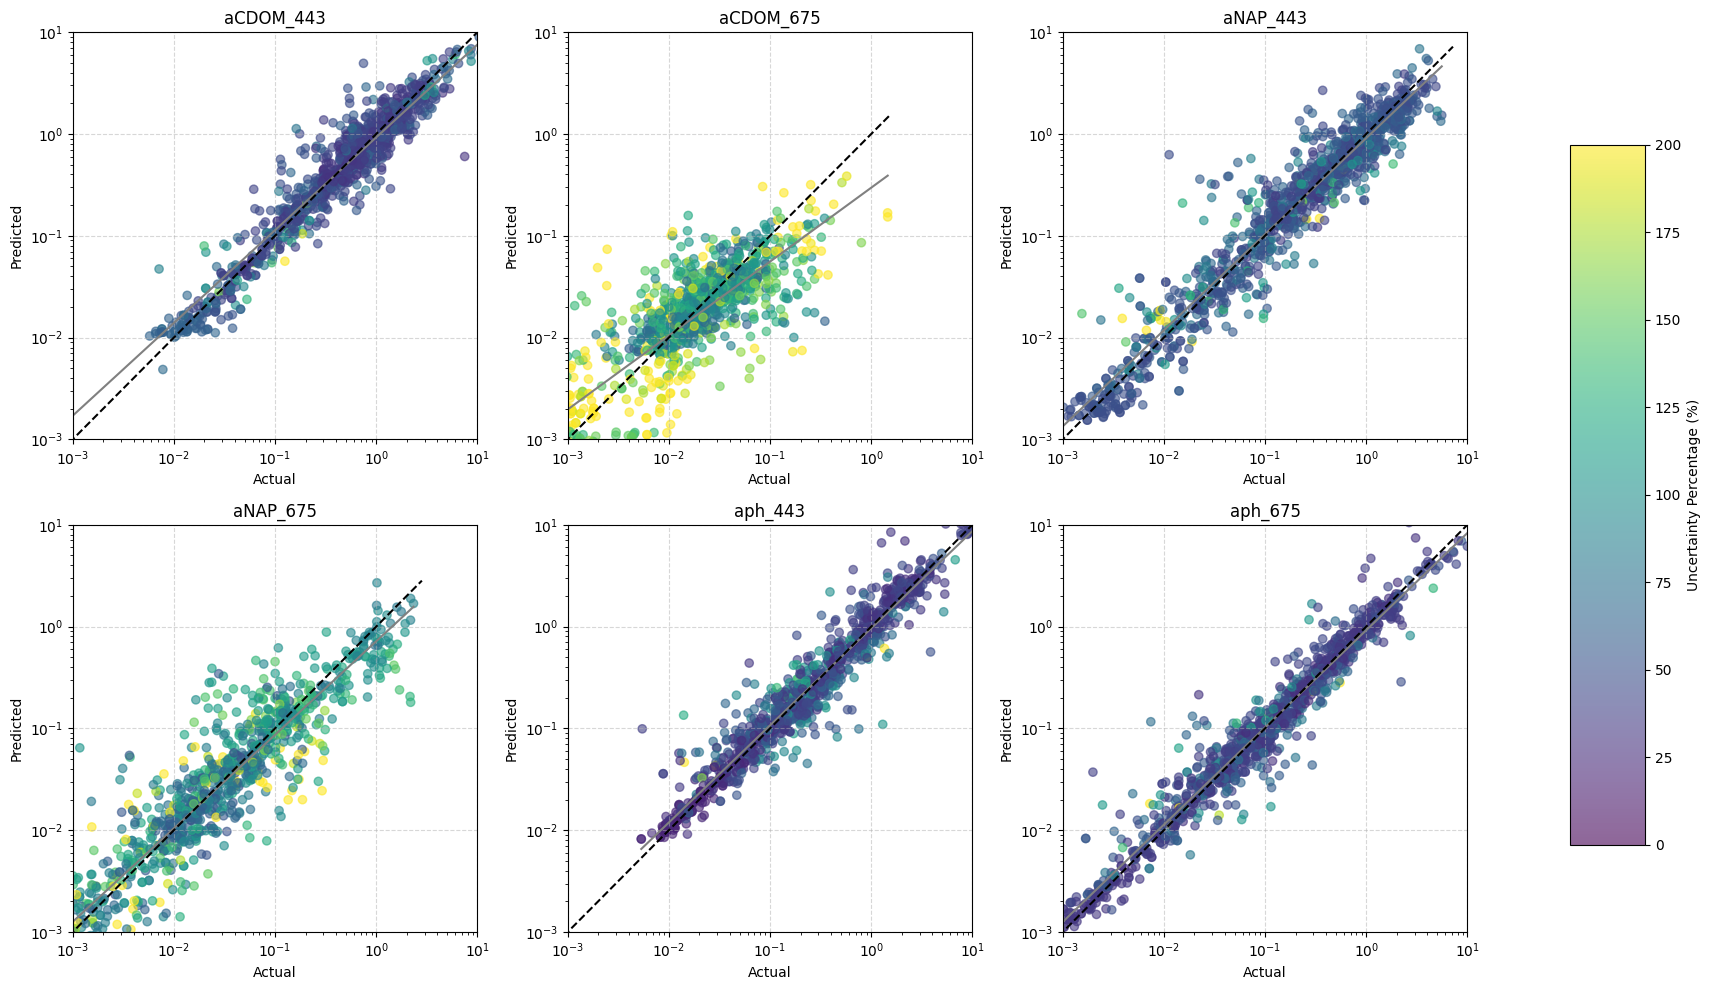

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Calculate percentage uncertainties relative to the mean predictions
percent_total_uncertainty = (np.sqrt(total_var) / mean_preds) * 100
percent_aleatoric_uncertainty = (np.sqrt(aleatoric_var) / mean_preds) * 100
percent_epistemic_uncertainty = (np.sqrt(epistemic_var) / mean_preds) * 100

# Create subplots: 2 rows, 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the array of axes for easy iterating
axs = axs.flatten()

# Apply the mask for values greater than 10^-4
mask = (y_test > 1e-4) & (mean_preds > 1e-4)

# Normalize the uncertainty values for the colormap within the range [0, 300]
norm = plt.Normalize(vmin=0, vmax=200)

# Titles for the subplots
titles = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']

for i, ax in enumerate(axs):
    # Apply the mask to both x and y values
    x_values = y_test[:, i][mask[:, i]]
    y_values = mean_preds[:, i][mask[:, i]]
    color_values = percent_total_uncertainty[:, i][mask[:, i]]  # Use the corresponding uncertainties

    # Scatter plot for actual vs. predicted, colored by total uncertainty
    sc = ax.scatter(x_values, y_values, c=color_values, cmap='viridis', norm=norm, alpha=0.6)
    # Linear regression in log-space
    slope, intercept, r_value, p_value, std_err = linregress(np.log(x_values), np.log(y_values))
    x_reg = np.linspace(min(x_values), max(x_values), 500)
    y_reg = np.exp(intercept + slope*np.log(x_reg))
    ax.plot(x_reg, y_reg, color='grey', label=f'Regression (R²={r_value**2:.2f})')

    # 1:1 Line
    limits = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(limits, limits, ls='--', color='black')


    ax.set_title(titles[i])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-3, 10)
    ax.set_ylim(1e-3, 10)
    ax.grid(True, ls='--', alpha=0.5)

# Adjust layout to prevent overlap
plt.tight_layout()

# Add a single colorbar to the right of the subplots
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])  # Position for the colorbar
cbar = plt.colorbar(mappable=sc, cax=cbar_ax, orientation='vertical', norm=norm)
cbar.set_label('Uncertainty Percentage (%)')

# Show plot
plt.show()


In [ ]:
import numpy as np
import pandas as pd

def calculate_metrics(y_true, y_pred):
    """
    Calculate the mean absolute percentage error (MAPE) and other metrics between true and predicted values.

    Args:
    - y_true: Actual values (numpy array).
    - y_pred: Predicted values (numpy array).

    Returns:
    - Tuple of metrics (obs_cor, MAPD, MAD, sspb, mdsa) for the predictions.
    """
    # Ensure y_true and y_pred are numpy arrays for element-wise operations
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate metrics assuming these functions are vectorized and can handle arrays
    mapd_values = mape(y_true, y_pred)
    mad_values = MAD(y_true, y_pred)
    sspb_values = sspb(y_true, y_pred)
    mdsa_values = mdsa(y_true, y_pred)

    # obs_cor is a scalar, all other values should be vectors of the same length as y_true/pred has columns
    obs_cor = len(y_pred)

    return obs_cor, mapd_values, mad_values, sspb_values, mdsa_values

# Calculate metrics for each target variable and store them in a DataFrame
def calculate_and_store_metrics(wd_y_test, wd_mean_predictions, y_columns):
    # Initialize a dictionary to hold the metrics
    metrics_dict = {'obs_cor': []}
    # Initialize keys for each metric with empty lists
    for metric_name in ['MAPD', 'MAD', 'sspb', 'mdsa']:
        metrics_dict[metric_name] = []

    # Calculate metrics for each target variable
    for i in range(wd_y_test.shape[1]):
        y_true = wd_y_test[:, i]
        y_pred = wd_mean_predictions[:, i]
        obs_cor, mapd, mad, sspb, mdsa = calculate_metrics(y_true, y_pred)

        # Append the scalar metrics
        metrics_dict['obs_cor'].append(obs_cor)
        metrics_dict['MAPD'].append(mapd)  # Assuming mapd is a scalar
        metrics_dict['MAD'].append(mad)    # Assuming mad is a scalar
        metrics_dict['sspb'].append(sspb)  # Assuming sspb is a scalar
        metrics_dict['mdsa'].append(mdsa)  # Assuming mdsa is a scalar

    # Create a DataFrame from the dictionary
    metrics_df = pd.DataFrame(metrics_dict, index=y_columns)

    return metrics_df

# Assuming wd_y_test, wd_mean_predictions are numpy arrays and y_columns is a list of column names
metrics_df = calculate_and_store_metrics(y_test, mean_preds, y_columns)


In [ ]:
metrics_df

obs_cor        MAPD       MAD      sspb       mdsa
aCDOM_443     1160   87.279183  0.339945 -3.131915  20.575224
aCDOM_675     1160  448.579417  0.965329 -0.712573  53.864790
aNAP_443      1160   56.006453  0.487646 -2.093134  33.600723
aNAP_675      1160   84.267728  0.723697 -2.659076  48.288112
aph_443       1160   34.791705  0.328480  1.905524  20.614832
aph_675       1160   34.996777  0.320078 -0.095278  19.740988

In [ ]:
from joblib import load

# Combining all arrays into a single array for easier manipulation
all_data = np.vstack([
    y_test,
    mean_preds,
    total_var,
    aleatoric_var,
    epistemic_var,
    std_preds
    # percent_total_uncertainty = (total_uncertainty / mean_predictions) * 100
    # percent_aleatoric_uncertainty = (aleatoric_uncertainty / mean_predictions) * 100
    # percent_epistemic_uncertainty = (epistemic_uncertainty / mean_predictions) * 100

])

# build the dict
indices = ['y_true', 'y_pred', 'total_var', 'ale_var', 'epi_var', 'std_dev']

# generate df, y_columns defined above
final_df_corrected = pd.DataFrame(all_data, columns=y_columns)

# assign the provided indices to groups of rows
final_df_corrected.index = np.repeat(indices, [1160, 1160, 1160, 1160, 1160, 1160])

final_df_corrected

# generating a MultiIndex for the DataFrame
multi_index_corrected = pd.MultiIndex.from_product([indices, range(1160)], names=['Category', 'Instance'])

# since all_data already combines everything correctly, simply apply the correct MultiIndex to the DataFrame
final_df_multi_indexed_corrected = pd.DataFrame(all_data, index=multi_index_corrected, columns=y_columns)

final_df_multi_indexed_corrected

#save
file_path = '/content/drive/My Drive/iop_ml/org_iop_model_predictions/ens_nn_random_split_preds.csv'
final_df_multi_indexed_corrected.to_csv(file_path)


In [ ]:
final_df_multi_indexed_corrected

aCDOM_443  aCDOM_675  aNAP_443  aNAP_675   aph_443  \
Category Instance                                                       
y_true   0          0.947503   0.013157  0.493835  0.037596  0.376750   
         1          0.414540   0.069090  0.420340  0.090161  0.504809   
         2          0.026055   0.000144  0.003446  0.000105  0.024749   
         3          0.898008   0.023026  0.683267  0.109841  0.445958   
         4          1.377664   0.029815  0.758037  0.036916  1.062832   
...                      ...        ...       ...       ...       ...   
std_dev  1155       0.209549   0.017099  0.079552  0.009023  0.069828   
         1156       0.052604   0.010784  0.010124  0.001355  0.022450   
         1157       0.181007   0.056677  0.133817  0.012996  0.313111   
         1158       0.030274   0.005159  0.004151  0.000471  0.013456   
         1159       0.330904   0.022688  0.292138  0.056903  0.179555   

                    aph_675  
Category Instance            
y_true   0         0.173178  
         1         0.307788  
         2         0.004854  
         3         0.304756  
         4         0.427353  
...                     ...  
std_dev  1155      0.036055  
         1156      0.011030  
         1157      0.127632  
         1158      0.005330  
         1159      0.081622  

[6960 rows x 6 columns]

# WD and OOD

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

# Select Rrs values in 5 nm steps
# Rrs data was already scaled
rrs_columns = [f'Rrs_{nm}' for nm in range(400, 701, 5)]
wd_X_train = wd_train_df[rrs_columns].values
wd_X_test = wd_test_df[rrs_columns].values

# Extracting target variables
y_columns = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']
wd_y_train = wd_train_df[y_columns].values
wd_y_test = wd_test_df[y_columns].values

# needs scaling
#Apply log transformation to the target variables
wd_y_train_log = np.log(wd_y_train)
wd_y_test_log = np.log(wd_y_test)

#Apply Min-Max scaling to log-transformed target variables
wd_scaler_y = MinMaxScaler(feature_range=(-1, 1))
wd_y_train_scaled = wd_scaler_y.fit_transform(wd_y_train_log)
wd_y_test_scaled = wd_scaler_y.transform(wd_y_test_log)

In [ ]:
# Parameters
num_models = 10
epochs = 1000
batch_size = 32
learning_rate = 0.001
depth = 5
width = 100
l2_reg = 1e-3

# Train the ensemble
wd_models, wd_histories = train_ensemble(
    wd_X_train,
    wd_y_train_scaled,
    num_models=num_models,
    epochs=epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    depth=depth,
    width=width,
    l2_reg=l2_reg
)


Epoch 1/1000
Epoch 1/1000
Epoch 1/1000
Epoch 1/1000
Epoch 1/1000
Epoch 1/1000
Epoch 1/1000
Epoch 1/1000
Epoch 1/1000
Epoch 1/1000


33/33 - 15s - loss: 1.1353 - val_loss: 1.2846 - 15s/epoch - 465ms/step
Epoch 2/1000
33/33 - 1s - loss: 0.6165 - val_loss: 1.9536 - 1s/epoch - 41ms/step
Epoch 3/1000
33/33 - 17s - loss: 1.3477 - val_loss: 1.1870 - 17s/epoch - 506ms/step
33/33 - 17s - loss: 1.0730 - val_loss: 1.1805 - 17s/epoch - 506ms/step
Epoch 2/1000
Epoch 2/1000
33/33 - 17s - loss: 1.0602 - val_loss: 2.1508 - 17s/epoch - 519ms/step
Epoch 2/1000
33/33 - 1s - loss: 0.4273 - val_loss: 4.0139 - 706ms/epoch - 21ms/step
Epoch 4/1000
33/33 - 18s - loss: 1.0977 - val_loss: 1.1502 - 18s/epoch - 536ms/step
Epoch 2/1000
33/33 - 1s - loss: 0.8387 - val_loss: 1.7311 - 765ms/epoch - 23ms/step
33/33 - 1s - loss: 0.6144 - val_loss: 1.6537 - 819ms/epoch - 25ms/step
Epoch 3/1000
Epoch 3/1000
33/33 - 18s - loss: 1.1517 - val_loss: 1.0371 - 18s/epoch - 541ms/step
Epoch 2/1000
33/33 - 18s - loss: 1.5361 - val_loss: 1.3490 - 18s/epoch - 549ms/step
33/33 - 18s - loss: 1.0766 - val_loss: 1.5816 - 18s/epoch - 544ms/step
Epoch 2/1000
Epoch 2/

In [ ]:
save_ensemble_models_histories(wd_models, wd_histories, base_folder='/content/drive/My Drive/iop_ml/best_models/wd_deep_regressor')
#wd_loaded_models, wd_loaded_histories = load_model_history('/content/drive/My Drive/iop_ml/best_models/wd_deep_regressor', num_models=10)
wd_mean_preds, wd_total_var, wd_aleatoric_var, wd_epistemic_var, wd_std_preds = predict_with_uncertainty_ensemble(wd_models, wd_X_test, wd_scaler_y)
metrics_df = calculate_and_store_metrics(wd_y_test, wd_mean_preds, y_columns)

In [ ]:
metrics_df

obs_cor        MAPD       MAD      sspb        mdsa
org_acdom_443     1160   46.243696  0.471576 -1.973776   33.181976
org_acdom_675     1160  468.495924  1.252551  1.105413   85.208441
org_anap_443      1160   77.264777  0.690790 -8.814949   50.457841
org_anap_675      1160  132.613629  1.353436  1.778786  104.891330
org_aph_443       1160   49.017517  0.447460  2.303660   32.334407
org_aph_675       1160   42.396760  0.457407 -9.961245   31.012113

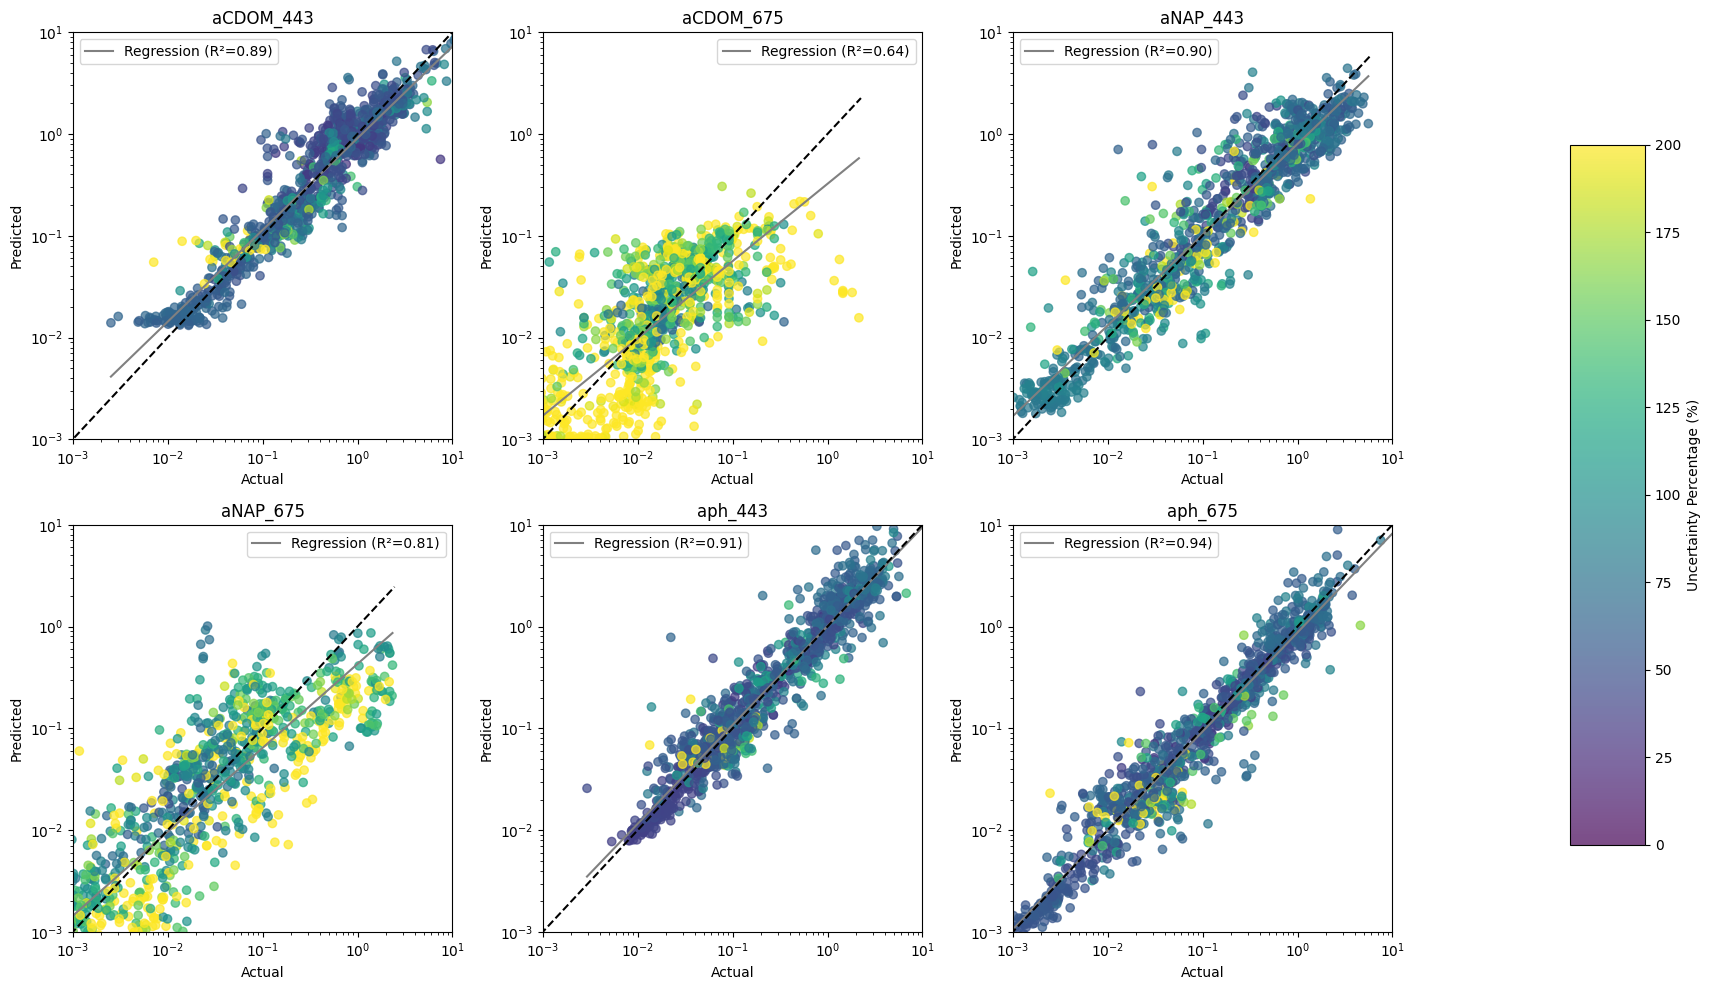

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Calculate percentage uncertainties relative to the mean predictions
wd_percent_total_uncertainty = (np.sqrt(wd_total_var) / wd_mean_preds) * 100
wd_percent_aleatoric_uncertainty = (np.sqrt(wd_aleatoric_var) / wd_mean_preds) * 100
wd_percent_epistemic_uncertainty = (np.sqrt(wd_epistemic_var) / wd_mean_preds) * 100

# Apply the mask for values greater than 10^-4
mask = (wd_y_test > 1e-4) & (wd_mean_preds > 1e-4)

# Normalize the uncertainty values for the colormap within the range [0, 300]
norm = plt.Normalize(vmin=0, vmax=200)

# Titles for the subplots
titles = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i, ax in enumerate(axs):
    x_values = wd_y_test[:, i][mask[:, i]]
    y_values = wd_mean_preds[:, i][mask[:, i]]
    color_values = wd_percent_total_uncertainty[:, i][mask[:, i]]

    # Scatter plot
    sc = ax.scatter(x_values, y_values, c=color_values, cmap='viridis', norm=norm, alpha=0.7)

    # Linear regression in log-space
    slope, intercept, r_value, p_value, std_err = linregress(np.log(x_values), np.log(y_values))
    x_reg = np.linspace(min(x_values), max(x_values), 500)
    y_reg = np.exp(intercept + slope*np.log(x_reg))
    ax.plot(x_reg, y_reg, color='grey', label=f'Regression (R²={r_value**2:.2f})')

    # 1:1 Line
    limits = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(limits, limits, ls='--', color='black')

    ax.set_title(titles[i])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-3, 10)
    ax.set_ylim(1e-3, 10)
    ax.legend()

plt.tight_layout(rect=[0, 0, 0.95, 1])
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
cbar = plt.colorbar(mappable=sc, cax=cbar_ax, orientation='vertical', norm=norm)
cbar.set_label('Uncertainty Percentage (%)')
plt.show()

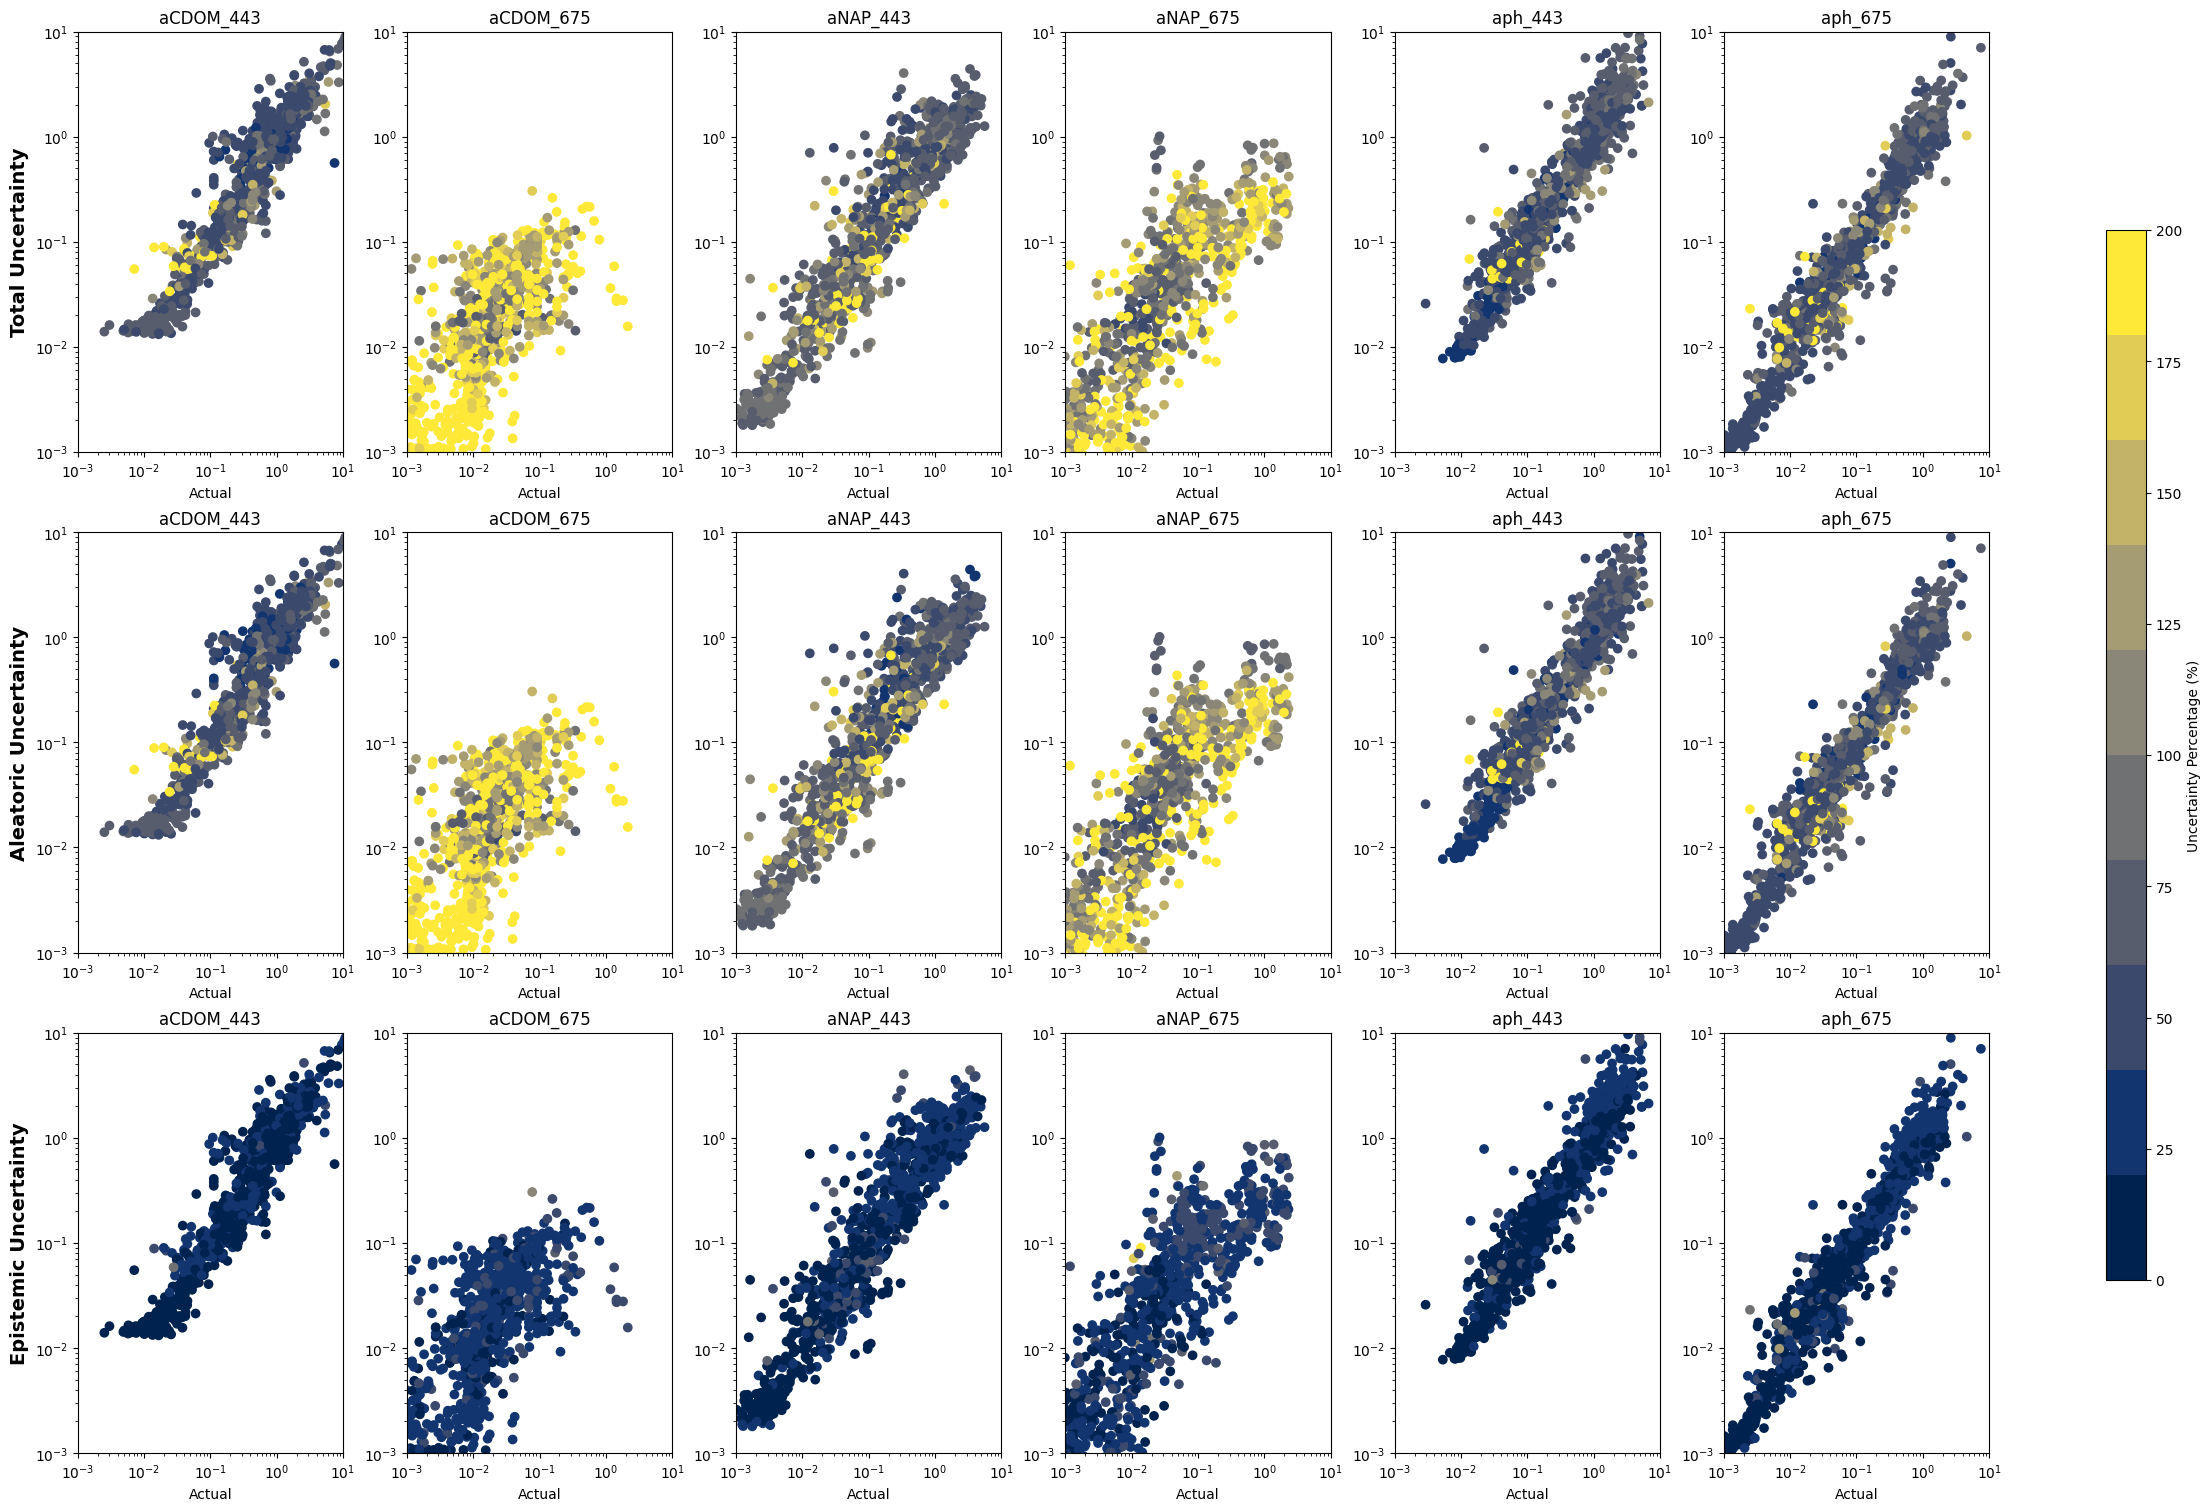

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Titles for the subplots
titles = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']
uncertainty_labels = ['Total Uncertainty', 'Aleatoric Uncertainty', 'Epistemic Uncertainty']

# Create a 3x6 subplot grid for each type of uncertainty and each variable
fig, axs = plt.subplots(3, 6, figsize=(20, 15), constrained_layout=True)

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Normalize the uncertainty values for the colormap within the range [0, 200]
norm = plt.Normalize(vmin=0, vmax=200)

# Function to create a discrete colormap
def create_discrete_colormap(cmap_name, num_bins=10):
    cmap = plt.get_cmap(cmap_name, num_bins)
    return cmap

# Create a discrete colormap with 'cividis'
cmap = create_discrete_colormap('cividis')

# Function to apply the mask and plot the data
def plot_uncertainty(ax, x_values, y_values, uncertainties, title, xlabel, ylabel=None):
    sc = ax.scatter(x_values, y_values, c=uncertainties, cmap=cmap, norm=norm, alpha=1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel, fontweight='bold', fontsize=14)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-3, 10)
    ax.set_ylim(1e-3, 10)
    return sc

# Apply the mask for values greater than 10^-4
mask = (wd_y_test > 1e-4) & (wd_mean_preds > 1e-4)

# Iterate over each uncertainty type
for i, uncertainty_label in enumerate(uncertainty_labels):
    # Select the appropriate uncertainty
    if uncertainty_label == 'Total Uncertainty':
        uncertainties = wd_percent_total_uncertainty
    elif uncertainty_label == 'Aleatoric Uncertainty':
        uncertainties = wd_percent_aleatoric_uncertainty
    else:  # 'Epistemic Uncertainty'
        uncertainties = wd_percent_epistemic_uncertainty

    # Iterate over each variable
    for j, title in enumerate(titles):
        # Calculate the index for the current subplot
        index = i * 6 + j
        # Apply the mask to both x and y values
        x_values = wd_y_test[:, j][mask[:, j]]
        y_values = wd_mean_preds[:, j][mask[:, j]]
        unc_values = uncertainties[:, j][mask[:, j]]
        # Plot the scatter plot for the current variable and uncertainty type
        ylabel = uncertainty_label if j == 0 else None
        sc = plot_uncertainty(axs[index], x_values, y_values, unc_values, title, 'Actual', ylabel)

# Add a colorbar to the right of the subplots
cbar_ax = fig.add_axes([1.05, 0.15, 0.02, 0.7])  # x, y, width, height
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('Uncertainty Percentage (%)')

plt.show()


In [ ]:
from joblib import load

# Combining all arrays into a single array for easier manipulation
all_data = np.vstack([
    wd_y_test,
    wd_mean_preds,
    wd_total_var,
    wd_aleatoric_var,
    wd_epistemic_var,
    wd_std_preds
    # percent_total_uncertainty = (total_uncertainty / mean_predictions) * 100
    # percent_aleatoric_uncertainty = (aleatoric_uncertainty / mean_predictions) * 100
    # percent_epistemic_uncertainty = (epistemic_uncertainty / mean_predictions) * 100

])

# build the dict
indices = ['y_true', 'y_pred', 'total_var', 'ale_var', 'epi_var', 'std_dev']

# generate df, y_columns defined above
final_df_corrected = pd.DataFrame(all_data, columns=y_columns)

# assign the provided indices to groups of rows
final_df_corrected.index = np.repeat(indices, [1160, 1160, 1160, 1160, 1160, 1160])

final_df_corrected

# generating a MultiIndex for the DataFrame
multi_index_corrected = pd.MultiIndex.from_product([indices, range(1160)], names=['Category', 'Instance'])

# since all_data already combines everything correctly, simply apply the correct MultiIndex to the DataFrame
final_df_multi_indexed_corrected = pd.DataFrame(all_data, index=multi_index_corrected, columns=y_columns)

final_df_multi_indexed_corrected

#save
file_path = '/content/drive/My Drive/iop_ml/org_iop_model_predictions/ens_nn_wd_split_preds.csv'
final_df_multi_indexed_corrected.to_csv(file_path)


# OOD

In [ ]:
#import pandas as pd

#Define the base path to the folder
base_path = '/content/drive/My Drive/iop_ml/datasets_train_test'

# Load the three in situ scenarios
random_train_df = pd.read_csv(f'{base_path}/random_df_train_org.csv')
random_test_df = pd.read_csv(f'{base_path}/random_df_test_org.csv')

wd_train_df = pd.read_csv(f'{base_path}/wd_train_set_org.csv')
wd_test_df = pd.read_csv(f'{base_path}/wd_test_set_org.csv')

ood_train_df = pd.read_csv(f'{base_path}/ood_train_set_2.csv')
ood_test_df = pd.read_csv(f'{base_path}/ood_test_set_2.csv')

filtered_df = pd.read_csv(f'{base_path}/filtered_df_2319.csv')

<ipython-input-58-844cab4c3881>:8: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  random_test_df = pd.read_csv(f'{base_path}/random_df_test_org.csv')
<ipython-input-58-844cab4c3881>:10: DtypeWarning: Columns (3,4,5,6,8,11,27,33,34,37,39,48,50,51,52,54,55,63) have mixed types. Specify dtype option on import or set low_memory=False.
  wd_train_df = pd.read_csv(f'{base_path}/wd_train_set_org.csv')
<ipython-input-58-844cab4c3881>:11: DtypeWarning: Columns (4,5,34,37,39,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  wd_test_df = pd.read_csv(f'{base_path}/wd_test_set_org.csv')
<ipython-input-58-844cab4c3881>:16: DtypeWarning: Columns (3,4,5,6,8,27,33,34,37,39,48,50,51,52,54,55,63) have mixed types. Specify dtype option on import or set low_memory=False.
  filtered_df = pd.read_csv(f'{base_path}/filtered_df_2319.csv')


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Extracting Rrs_ values as inputs
ood_X_train = ood_train_df[[f'Rrs_{nm}' for nm in range(400, 701, 5)]]
ood_X_test = ood_test_df[[f'Rrs_{nm}' for nm in range(400, 701, 5)]]

# Extracting target variables
#y_columns = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']
y_columns = ['org_acdom_443', 'org_acdom_675', 'org_anap_443', 'org_anap_675','org_aph_443', 'org_aph_675']
ood_y_train = ood_train_df[y_columns].values
ood_y_test = ood_test_df[y_columns].values

# Apply log transformation to the target variables
ood_y_train_log = np.log(ood_y_train)
ood_y_test_log = np.log(ood_y_test)

# Apply Min-Max scaling to log-transformed target variables
ood_scaler_y = MinMaxScaler(feature_range=(-1, 1))
ood_y_train_scaled = ood_scaler_y.fit_transform(ood_y_train_log)
ood_y_test_scaled = ood_scaler_y.transform(ood_y_test_log)

In [ ]:
# Parameters
num_models = 10
epochs = 1000
batch_size = 32
learning_rate = 0.001
depth = 5
width = 100
l2_reg = 1e-3

# Train the ensemble
ood_models, ood_histories = train_ensemble(
    ood_X_train,
    ood_y_train_scaled,
    num_models=num_models,
    epochs=epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    depth=depth,
    width=width,
    l2_reg=l2_reg
)


Epoch 1/1000
Epoch 1/1000
Epoch 1/1000
Epoch 1/1000
Epoch 1/1000
Epoch 1/1000
Epoch 1/1000
Epoch 1/1000
Epoch 1/1000
Epoch 1/1000
33/33 - 20s - loss: 1.0943 - val_loss: 2.7681 - 20s/epoch - 611ms/step
33/33 - 20s - loss: 0.9375 - val_loss: 3.4037 - 20s/epoch - 615ms/step
Epoch 2/1000
Epoch 2/1000
33/33 - 21s - loss: 0.9621 - val_loss: 2.0208 - 21s/epoch - 623ms/step
Epoch 2/1000
33/33 - 21s - loss: 1.0115 - val_loss: 1.9065 - 21s/epoch - 637ms/step
Epoch 2/1000
33/33 - 21s - loss: 1.1044 - val_loss: 1.7211 - 21s/epoch - 638ms/step
Epoch 2/1000
33/33 - 1s - loss: 5.2985 - val_loss: 1.2743 - 985ms/epoch - 30ms/step
Epoch 3/1000
33/33 - 1s - loss: 0.4835 - val_loss: 3.7664 - 1s/epoch - 31ms/step
Epoch 3/1000
33/33 - 21s - loss: 1.0252 - val_loss: 1.4215 - 21s/epoch - 648ms/step
Epoch 2/1000
33/33 - 1s - loss: 0.6165 - val_loss: 6.4687 - 1s/epoch - 30ms/step
Epoch 3/1000
33/33 - 21s - loss: 0.9041 - val_loss: 1.7891 - 21s/epoch - 650ms/step
Epoch 2/1000
33/33 - 22s - loss: 0.9921 - val_los

In [ ]:
save_ensemble_models_histories(ood_models, ood_histories, base_folder='/content/drive/My Drive/iop_ml/best_models/ood_deep_regressor')
#ood_loaded_models, ood_loaded_histories = load_model_history('/content/drive/My Drive/iop_ml/best_models/ood_deep_regressor', num_models=10)
ood_mean_preds, ood_total_var, ood_aleatoric_var, ood_epistemic_var, ood_std_preds = predict_with_uncertainty_ensemble(ood_models, ood_X_test, ood_scaler_y)
ood_metrics_df = calculate_and_store_metrics(ood_y_test, ood_mean_preds, y_columns)

In [ ]:
ood_metrics_df

obs_cor         MAPD       MAD       sspb       mdsa
org_acdom_443     1159    59.945780  0.586984   2.200824  35.775515
org_acdom_675     1159   330.820857  1.242971 -40.677838  80.583805
org_anap_443      1159   190.912532  1.032191 -58.644904  81.458640
org_anap_675      1159  4158.770822  1.696048 -22.175807  99.947641
org_aph_443       1159    73.874212  0.640237  -1.531241  40.145321
org_aph_675       1159    70.936444  0.662969   1.282570  43.244876

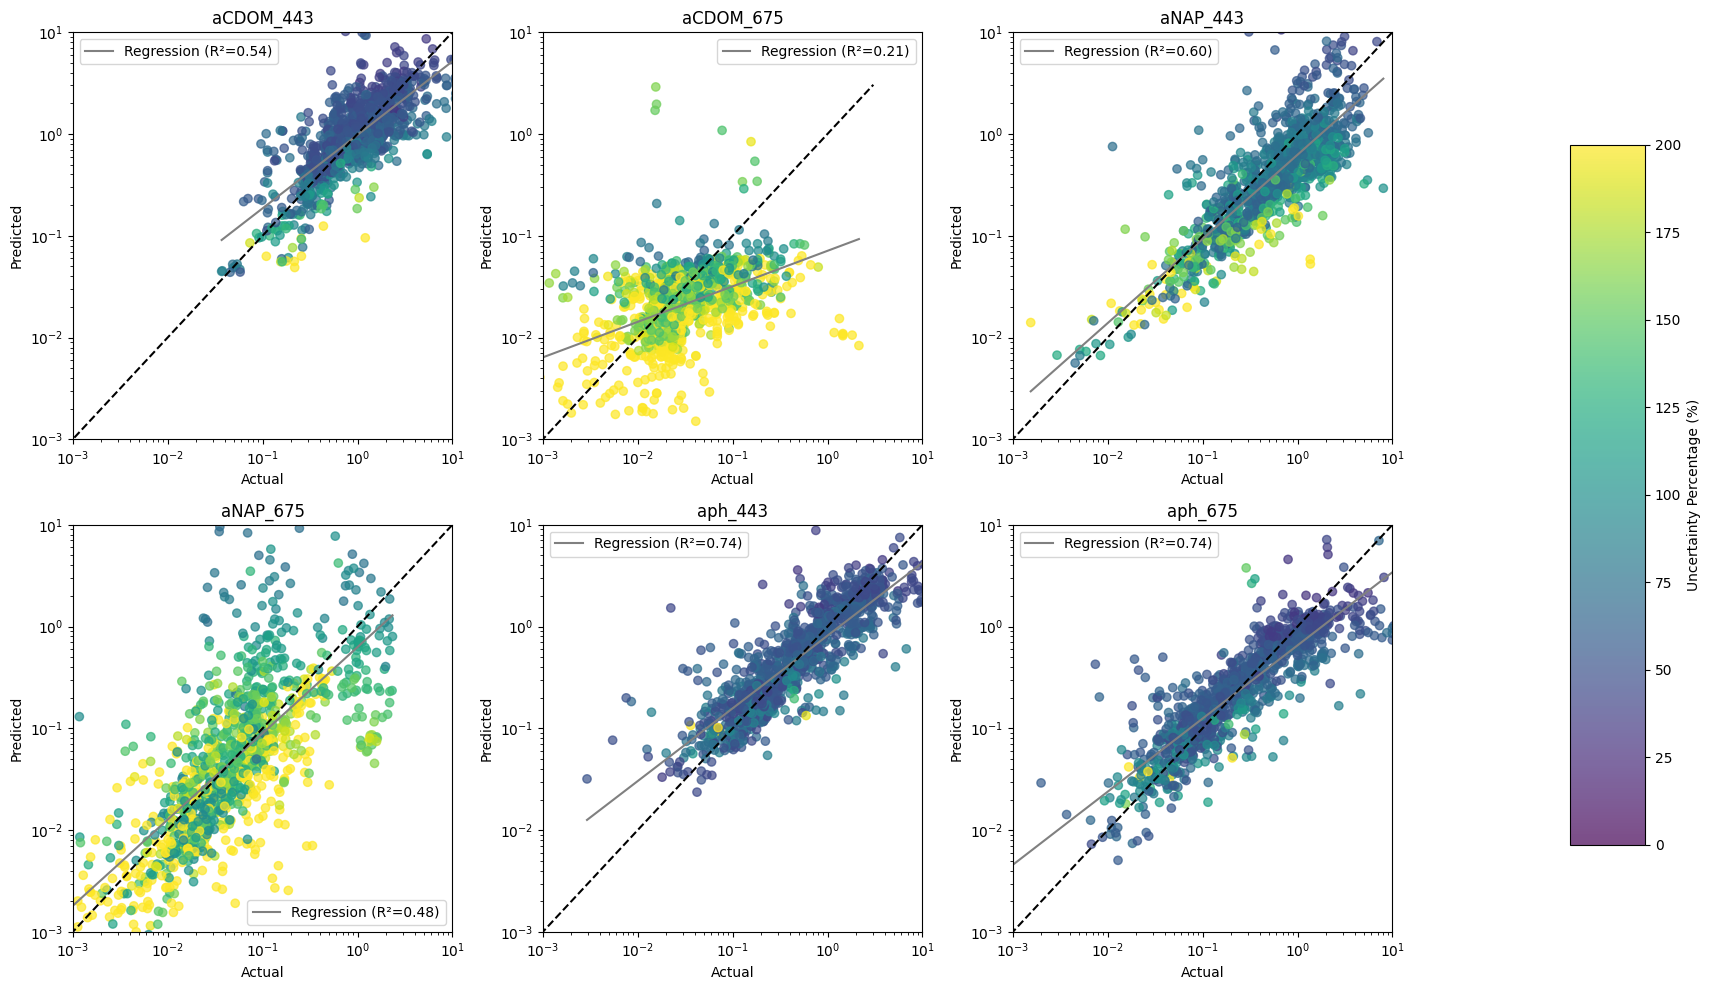

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Calculate percentage uncertainties relative to the mean predictions
ood_percent_total_uncertainty = (np.sqrt(ood_total_var) / ood_mean_preds) * 100
ood_percent_aleatoric_uncertainty = (np.sqrt(ood_aleatoric_var) / ood_mean_preds) * 100
ood_percent_epistemic_uncertainty = (np.sqrt(ood_epistemic_var) / ood_mean_preds) * 100

# Apply the mask for values greater than 10^-4
mask = (ood_y_test > 1e-4) & (ood_mean_preds > 1e-4)

# Normalize the uncertainty values for the colormap within the range [0, 300]
norm = plt.Normalize(vmin=0, vmax=200)

# Titles for the subplots
titles = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i, ax in enumerate(axs):
    x_values = ood_y_test[:, i][mask[:, i]]
    y_values = ood_mean_preds[:, i][mask[:, i]]
    color_values = ood_percent_total_uncertainty[:, i][mask[:, i]]

    # Scatter plot
    sc = ax.scatter(x_values, y_values, c=color_values, cmap='viridis', norm=norm, alpha=0.7)

    # Linear regression in log-space
    slope, intercept, r_value, p_value, std_err = linregress(np.log(x_values), np.log(y_values))
    x_reg = np.linspace(min(x_values), max(x_values), 500)
    y_reg = np.exp(intercept + slope*np.log(x_reg))
    ax.plot(x_reg, y_reg, color='grey', label=f'Regression (R²={r_value**2:.2f})')

    # 1:1 Line
    limits = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(limits, limits, ls='--', color='black')

    ax.set_title(titles[i])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-3, 10)
    ax.set_ylim(1e-3, 10)
    ax.legend()

plt.tight_layout(rect=[0, 0, 0.95, 1])
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
cbar = plt.colorbar(mappable=sc, cax=cbar_ax, orientation='vertical', norm=norm)
cbar.set_label('Uncertainty Percentage (%)')
plt.show()

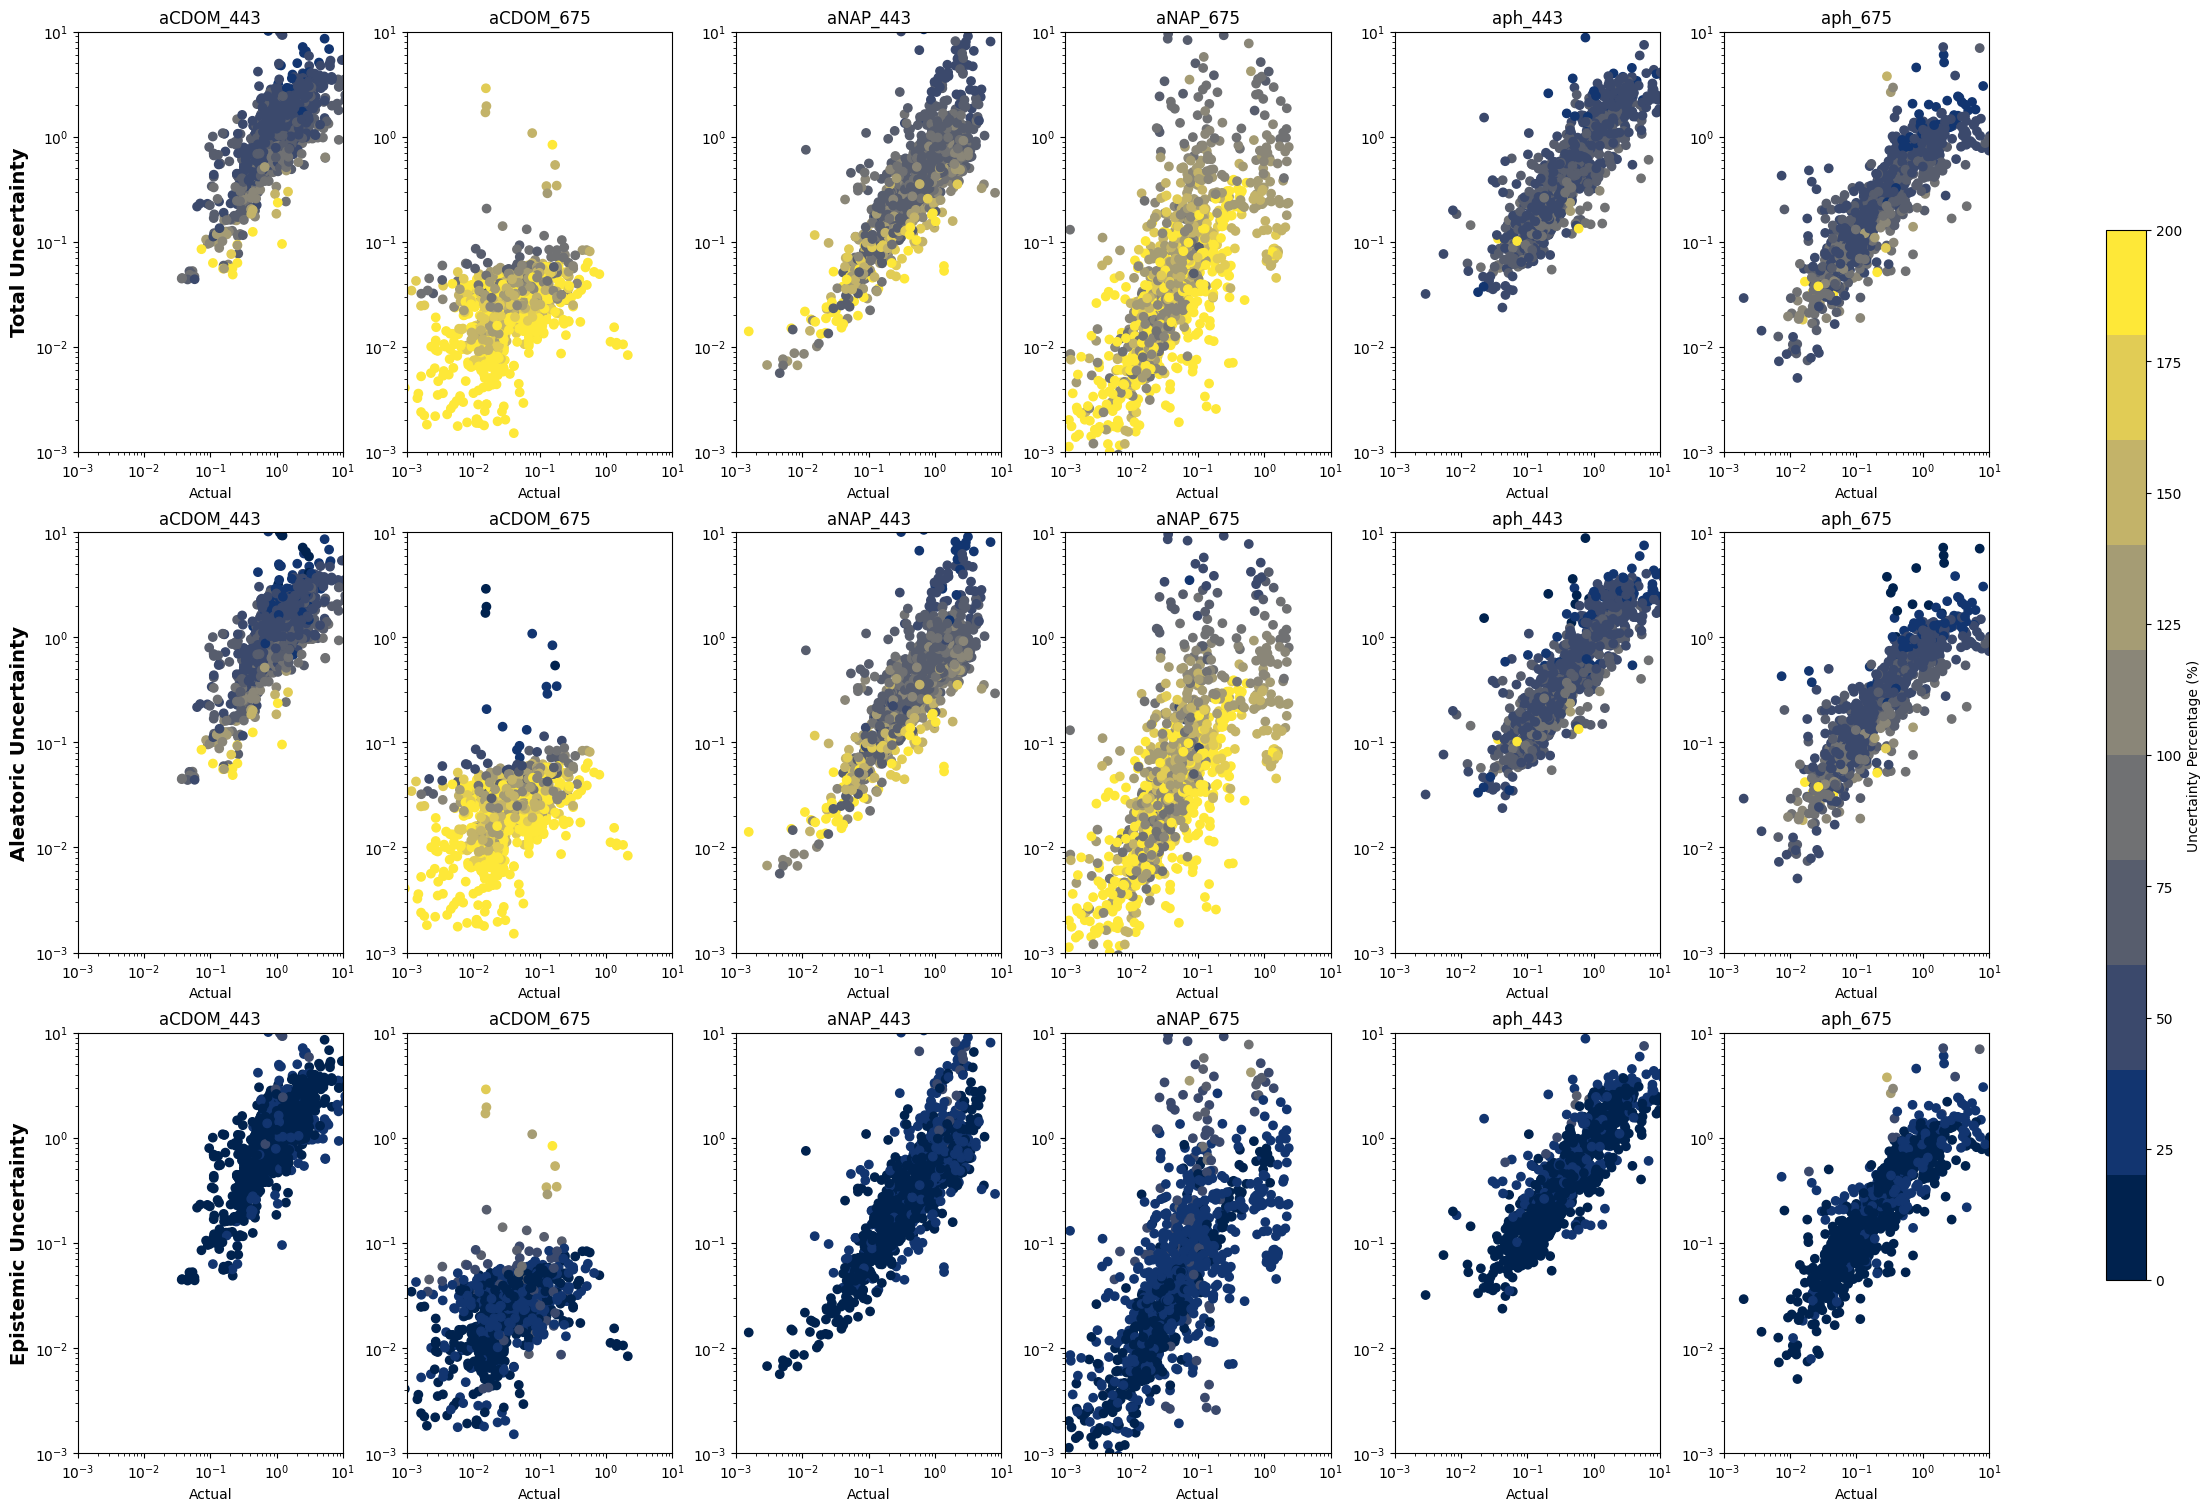

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Titles for the subplots
titles = ['aCDOM_443', 'aCDOM_675', 'aNAP_443', 'aNAP_675', 'aph_443', 'aph_675']
uncertainty_labels = ['Total Uncertainty', 'Aleatoric Uncertainty', 'Epistemic Uncertainty']

# Create a 3x6 subplot grid for each type of uncertainty and each variable
fig, axs = plt.subplots(3, 6, figsize=(20, 15), constrained_layout=True)

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Normalize the uncertainty values for the colormap within the range [0, 200]
norm = plt.Normalize(vmin=0, vmax=200)

# Function to create a discrete colormap
def create_discrete_colormap(cmap_name, num_bins=10):
    cmap = plt.get_cmap(cmap_name, num_bins)
    return cmap

# Create a discrete colormap with 'cividis'
cmap = create_discrete_colormap('cividis')

# Function to apply the mask and plot the data
def plot_uncertainty(ax, x_values, y_values, uncertainties, title, xlabel, ylabel=None):
    sc = ax.scatter(x_values, y_values, c=uncertainties, cmap=cmap, norm=norm, alpha=1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel, fontweight='bold', fontsize=14)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-3, 10)
    ax.set_ylim(1e-3, 10)
    return sc

# Apply the mask for values greater than 10^-4
mask = (ood_y_test > 1e-4) & (ood_mean_preds > 1e-4)

# Iterate over each uncertainty type
for i, uncertainty_label in enumerate(uncertainty_labels):
    # Select the appropriate uncertainty
    if uncertainty_label == 'Total Uncertainty':
        uncertainties = ood_percent_total_uncertainty
    elif uncertainty_label == 'Aleatoric Uncertainty':
        uncertainties = ood_percent_aleatoric_uncertainty
    else:  # 'Epistemic Uncertainty'
        uncertainties = ood_percent_epistemic_uncertainty

    # Iterate over each variable
    for j, title in enumerate(titles):
        # Calculate the index for the current subplot
        index = i * 6 + j
        # Apply the mask to both x and y values
        x_values = ood_y_test[:, j][mask[:, j]]
        y_values = ood_mean_preds[:, j][mask[:, j]]
        unc_values = uncertainties[:, j][mask[:, j]]
        # Plot the scatter plot for the current variable and uncertainty type
        ylabel = uncertainty_label if j == 0 else None
        sc = plot_uncertainty(axs[index], x_values, y_values, unc_values, title, 'Actual', ylabel)

# Add a colorbar to the right of the subplots
cbar_ax = fig.add_axes([1.05, 0.15, 0.02, 0.7])  # x, y, width, height
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('Uncertainty Percentage (%)')

plt.show()


In [ ]:
from joblib import load

# Combining all arrays into a single array for easier manipulation
all_data = np.vstack([
    ood_y_test,
    ood_mean_preds,
    ood_total_var,
    ood_aleatoric_var,
    ood_epistemic_var,
    ood_std_preds
    # percent_total_uncertainty = (total_uncertainty / mean_predictions) * 100
    # percent_aleatoric_uncertainty = (aleatoric_uncertainty / mean_predictions) * 100
    # percent_epistemic_uncertainty = (epistemic_uncertainty / mean_predictions) * 100

])

# build the dict
indices = ['y_true', 'y_pred', 'total_var', 'ale_var', 'epi_var', 'std_dev']

# generate df, y_columns defined above
final_df_corrected = pd.DataFrame(all_data, columns=y_columns)

# assign the provided indices to groups of rows
final_df_corrected.index = np.repeat(indices, [1159, 1159, 1159, 1159, 1159, 1159])

final_df_corrected

# generating a MultiIndex for the DataFrame
multi_index_corrected = pd.MultiIndex.from_product([indices, range(1159)], names=['Category', 'Instance'])

# since all_data already combines everything correctly, simply apply the correct MultiIndex to the DataFrame
final_df_multi_indexed_corrected = pd.DataFrame(all_data, index=multi_index_corrected, columns=y_columns)

final_df_multi_indexed_corrected

#save
file_path = '/content/drive/My Drive/iop_ml/org_iop_model_predictions/ens_nn_ood_split_preds.csv'
final_df_multi_indexed_corrected.to_csv(file_path)
